# W251 - Final Projects - Skeggox Team

* Parham Motameni 
* Mitchell Karchemsky
* Lynn Marciano

The majority of parameters can be configured, including some of the optimization techniques. Check out the configuration section for details.


In [1]:
%%capture
from pathlib import Path
data_path = 'grab.zip'
data_file = Path(data_path)
if data_file.is_file():
  print("Data file is already loaded.")
else :
  !pip install timm
  !pip install albumentations==0.4.6
  !pip install gdown
  !mkdir -p 'grab'
  !mkdir -p 'checkpoints'
  !gdown --id '1c8thCkdHJaoF4hLffi8ne-ULh4FPrPdy' # images
  !unzip -qq 'grab.zip'
  !gdown --id '1Yf-IiNncjaHKI_qQq76p4wmW-FHTZSQu' #checkpoint
  !mv 'checkpoint.pth.tar' 'checkpoints/'

In [2]:
import time
import os
from tqdm import tqdm_notebook as tqdm
#import tqdm.notebook import tqdm
import cv2
from PIL import Image
import pandas as pd
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt
import random
import numpy as np
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import shutil
import timm
import torch.nn.functional as F
from torch.nn.modules.loss import _WeightedLoss
import torchvision.datasets as datasets
from timm.scheduler.cosine_lr import CosineLRScheduler
from torch.cuda.amp import autocast, GradScaler
import torch.backends.cudnn as cudnn
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import warnings

warnings.filterwarnings('ignore')

# Configuration

The majority of parameters can be configured, including some of the optimization techniques.

The following optimizations can be used by setting proper configuration arguments
1. Learning Rate Schedular - Step Schedular or CosineLRScheduler
2. Different arch using mixnet_xl 

The following optimizations are applied 
1. Mixup
2. Label Smoothing
3. Scaler for Mixed Precision

In [3]:
class args:
  arch = 'mixnet_xl'
  # arch = 'efficientnet_b2' 
  batch_size = 5 #96
  beta = .1
  cudnn_benchmark = True
  cudnn_deterministic = True
  epochs = 50
  # epochs = 15
  folds = 8
  gpu = 0
  img_size = 224
  img_mean_RGB = [0.47889522, 0.47227842, 0.43047404]
  img_std_RGB = [0.229, 0.224, 0.225]
  log_level =  'verbose' # options: verbose, None
  lr = 0.0001 # learning rate
  lr_min=0.00001 # min learning rate when using a LR Scheduler
  momentum = 0.9 # a setting for Optimizer
  warmup_epochs = 2 # a setting for Cosine LR Scheduler
  num_classes = 3 # number of categories 
  num_workers = 8 
  pretrained = True # determine if the weights of pre-build model should be used 
  print_freq = 50
  project_name = 'skeggox'
  resume = True # when it is True it will continue from last saved checkpoint
  save_checkpoint = True # save both last and best acc checkpoints
  save_checkpoint_per_epoch = True # save one file per epoch along best acc 
  seed = 1
  schedular_type = 'step' # option: 'cosine', 'step'(DEFAULT)
  start_epoch = 0
  test_batch_size = 128
  test_dir = 'grab/train'
  train_batch_size = 128
  train_dir = 'grab/train'
  warm = 4
  warmup_lr_init = 0.00001 # for Cosine LR
  weight_decay = 0.00001

In [4]:
class state:
  best_acc = 0
  start_epoch = 0

# Transformers

In [5]:
class CustomTransforms():
  def __init__(self):
    self.train_transform = CustomTransforms.create_train_transform()
    self.test_transform = CustomTransforms.create_test_transform()

  @staticmethod
  def create_train_transform():
     return A.Compose([
        A.Resize(args.img_size, args.img_size),
        # TODO: Note if we want LC and RC labled separately 
        #     then we need to remove  A.HorizontalFlip
        A.HorizontalFlip(p=0.5), # this miror the image keep it 
        ToTensorV2(),
        ])
  @staticmethod
  def create_test_transform():
    return A.Compose([
        A.Resize(args.img_size, args.img_size),
        ToTensorV2(),
    ])

# Load Dataset

In [6]:
class SkeggoxDataset(Dataset):
    def __init__(self, df, mode, img_dir, transform=None):
        self.data = df
        self.img_dir = img_dir
        self.transform = transform
        self.mode = mode

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):        
        fname = self.data.iloc[idx]['filename']
        img_path = (f'{self.img_dir}/{fname}')
        image = cv2.imread(img_path)
        if self.transform is not None:
          image = self.transform(image = image)['image']
        image = image.float() / 255.
        label = -1 if self.mode=='test' else self.data.iloc[idx]['label']
        
        return image, label

In [7]:
class DataCollections():
  def __init__(self):
    self.load_datasets()
    self.build_dataloaders()

  def load_datasets(self):
    alldf = pd.read_csv(f'grab/train.csv')
    # if you want to change the file path 
    # alldf['filename'] = 'train/' + alldf['filename'] + '.jpeg'

    y = alldf['label']
    trndf = pd.DataFrame()
    tstdf = pd.DataFrame() 
    valdf = pd.DataFrame()
    # this is temp holder for now to hold both tr and val
    tr_val_df = pd.DataFrame()

    # Split the training dataset into a training and a validation

    # NOTE: pick some training for testing first!! (TODO we need to be able to load new data 
    # so better to have a separate test from train/val to avoid re-run for whole set)
    tr_val_df['filename'], tstdf['filename'], tr_val_df['label'], tstdf['label'] = \
      train_test_split( alldf['filename'], y, test_size=0.10, 
                       random_state=4, stratify=y)
    # because we sue the first split for test we need this second one for validation
    y = tr_val_df['label']
    trndf['filename'], valdf['filename'], trndf['label'], valdf['label'] = \
    train_test_split( tr_val_df['filename'], y, test_size=0.10, 
                     random_state=4, stratify=y)
    
    # (TODO correct loader for test data when it is ready) Load our test data
    # tstdf = pd.read_csv(f'grab/test.csv')

    # if you want to change the file path 
    # tstdf['filename'] = 'test/' + tstdf['filename'] + '.jpeg'

    if args.log_level == 'verbose':
      print('alldf:', alldf.shape, 'train:', trndf.shape,
          'val:', valdf.shape, 'test', tstdf.shape)
      labels = [1, 3, 5, 10, 11, 12]
      dfs = { 'train':trndf,'val': valdf, 'test':tstdf}
      for df_key in dfs:
        df = dfs.get(df_key)
        total = df.shape[0]
        print(df_key, 'total:', total)
        [print(df_key, total, l, df[df['label']==l].shape[0]/total) for l in labels]

    custom_transforms = CustomTransforms()

    self.train_dataset = SkeggoxDataset(trndf,  'train', args.train_dir,  custom_transforms.train_transform)
    self.validate_dataset = SkeggoxDataset(valdf, 'train', args.train_dir, custom_transforms.train_transform)
    self.test_dataset = SkeggoxDataset(tstdf, 'test', args.test_dir, custom_transforms.test_transform)

    # return train_dataset, validate_dataset, test_dataset

  def build_dataloaders(self):

    loaderargs = {'num_workers' : args.num_workers, 'batch_size':args.batch_size,
                  'pin_memory': False, 'drop_last': False}
  
    self.train_dataloader = DataLoader(self.train_dataset, shuffle = True, **loaderargs)
    self.validate_dataloader = DataLoader(self.validate_dataset, shuffle = False, **loaderargs)
    self.test_dataloader = DataLoader(self.test_dataset, shuffle = False, **loaderargs)

# Save and Resume 

In [8]:
def save_checkpoint(state, is_best):
  if args.save_checkpoint or args.save_checkpoint_per_epoch:
    folder = 'checkpoints/'
    filename = f'{folder}checkpoint.pth.tar'
    torch.save(state,  filename)
    if args.save_checkpoint_per_epoch:
      shutil.copyfile(filename, f'{folder}checkpoint_{state["epoch"]}.pth.tar')
    if is_best:
      shutil.copyfile(filename, f'{folder}model_best.pth.tar')

In [9]:
def resume(sk_model, filename = 'checkpoints/checkpoint.pth.tar' ):
  if args.resume:
    if os.path.isfile(filename):
      print(f'=> loading checkpoint: {filename}')
      checkpoint = torch.load(filename, map_location=sk_model.device)
      state.start_epoch = checkpoint['epoch']
      state.best_acc = checkpoint['best_acc']
      # state.best_acc = best_acc.to(GPU)
      sk_model.model.load_state_dict(checkpoint['state_dict'])
      sk_model.optimizer.load_state_dict(checkpoint['optimizer'])
      print(f'=> loaded checkpoint {filename}',
            f'epoch {state.start_epoch}')
    else:
        print(f'=> no checkpoint found at {filename}')

# Set Model

In [10]:
class SkeggoxMetrics:
  def __init__(self):
    self.lr_list = []

In [11]:
# Label Smoothing for Cross Entropy Loss fucntion
# From https://github.com/pytorch/pytorch/issues/7455#issuecomment-759175034
class LabelSmoothCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=0.0):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    @staticmethod
    def _smooth_one_hot(targets: torch.Tensor, n_classes: int, smoothing=0.0):
        assert 0 <= smoothing < 1
        with torch.no_grad():
            targets = torch.empty(size=(targets.size(0), n_classes),
                                  device=targets.device) \
                .fill_(smoothing / (n_classes - 1)) \
                .scatter_(1, targets.data.unsqueeze(1), 1. - smoothing)
        return targets

    def forward(self, inputs, targets):
        targets = LabelSmoothCrossEntropyLoss._smooth_one_hot(targets, inputs.size(-1),
                                                              self.smoothing)
        lsm = F.log_softmax(inputs, -1)

        if self.weight is not None:
            lsm = lsm * self.weight.unsqueeze(0)

        loss = -(targets * lsm).sum(-1)

        if self.reduction == 'sum':
            loss = loss.sum()
        elif self.reduction == 'mean':
            loss = loss.mean()

        return loss

In [12]:
class SkeggoxModel():
  def __init__(self, device, arch, num_steps, pretrained = False):
    self.device = device
    self.pretrained = pretrained
    self.arch = arch
    self.num_steps = num_steps
    self.metrics = SkeggoxMetrics()

    self.create_model()
    self.create_criterion()
    self.create_optimizer()
    self.create_scheduler()
    # define scaler for Mixed Precision
    self.scaler = GradScaler()
    
  
  def create_model(self):
    # TODO you can add custom model instead of using pre-built model here
    model = timm.create_model(self.arch, pretrained = self.pretrained)
    # # model = models.__dict__[args.arch]()
    # inf = model.fc.in_features
    # model.fc = nn.Linear(inf, args.num_classes)
    # model.cuda(args.gpu)
    self.model = model.to(self.device)

  def create_criterion(self):
    ## Non-smoothing version
    # self.criterion = torch.nn.CrossEntropyLoss()
    ## the smoothing version
    self.criterion = LabelSmoothCrossEntropyLoss(smoothing=0.3)
  
  def create_optimizer(self):
    # Adam Optimizer
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr=args.lr)
    # SGD Optimizer
    # self.optimizer =  torch.optim.SGD(self.model.parameters(), 
    #                        args.lr,
    #                        momentum=args.momentum,
    #                        weight_decay=args.weight_decay)

  def create_scheduler(self):
    if args.schedular_type == 'cosine':
      # Cosine LR
      steps = self.num_steps
      self.scheduler = CosineLRScheduler(
              self.optimizer,
              t_initial = steps * args.epochs + 1,
              lr_min = args.lr_min,
              warmup_lr_init = args.warmup_lr_init,
              warmup_t = steps * args.warmup_epochs + 1)
    else:
      # step LR
      self.scheduler = lr_scheduler.StepLR(self.optimizer, step_size=10)

# Train and Validate

In [13]:
def train(sk_model, dl, global_step):
  print(f'Epoch {epoch}/{args.epochs - 1}')
  device = sk_model.device
  model = sk_model.model
  metrics = sk_model.metrics
  optimizer = sk_model.optimizer
  scaler = sk_model.scaler
  sk_model.scheduler.step(global_step) if args.schedular_type == 'cosine' \
      else sk_model.scheduler.step()
 
  model.train()
  running_loss = 0.0
  train_d = dl.train_dataloader
  tk0 = tqdm(train_d, total=int(len(train_d)))
  for step, batch in enumerate(tk0):
      inputs = batch[0].to(device, dtype=torch.float)
      labels = batch[1].to(device).long()

      ## Mixup
      # Get out a random value form a distribution    
      lam = np.random.beta(args.beta, args.beta)
      rand_index = torch.randperm(inputs.size()[0]).to(device) # make an index which reorders the batch

      # Reorder the labels
      labels_a = labels
      labels_b = labels[rand_index]

      # Partially mixup up the batch
      inputs_mixed = lam * inputs + (1 - lam) * inputs[rand_index]

      optimizer.zero_grad()

      # Runs the forward pass with autocasting.
      with autocast():
          # using mixed up input for model
          outputs = model(inputs_mixed)            
          # Partial loss against original labels, partial loss against mixed up labels
          loss = sk_model.criterion(outputs, labels_a) * lam + \
              sk_model.criterion(outputs, labels_b) * (1. - lam)
      

      # outputs = model(inputs)
      # loss = sk_model.criterion(outputs, labels)

      # Scaler
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()

      # non-scaler
      # loss.backward()
      # optimizer.step()

      running_loss += loss.item()
      tk0.set_postfix(train_loss=(running_loss / (step+1)))

      global_step += 1
      # print(optimizer.param_groups[0]['lr'])
      metrics.lr_list.append(optimizer.param_groups[0]['lr']) 


In [14]:
def validate(sk_model, dl):
  valpreds = []
  device = sk_model.device
  model = sk_model.model
  model.eval()
  running_loss = 0.0
  val_d = dl.validate_dataloader
  tkval = tqdm(val_d, total=int(len(val_d)))
  for step, batch in enumerate(tkval):
      inputs = batch[0].to(device, dtype=torch.float)
      labels = batch[1].to(device).long()
      with torch.no_grad():
          outputs = model(inputs)
          loss = sk_model.criterion(outputs, labels)
      valpreds.append(outputs)
      running_loss += loss.item()
      tkval.set_postfix(valid_loss=(running_loss / (step+1)))
  preds = torch.cat(valpreds).argmax(1).detach().cpu().numpy()
  acc = (dl.validate_dataset.data.label.values == preds).mean()
  print(f'Valid accuracy {acc:.4f}')
  # print confusion matrix
  if args.log_level == 'verbose':
    print(confusion_matrix(dl.validate_dataset.data.label.values, preds))
    print(dl.validate_dataset.data.label.values)
  
  is_best = acc > state.best_acc
  state.best_acc = max(acc, state.best_acc)

  save_checkpoint({
      'epoch': epoch + 1,
      'step': step + 1,
      'arch': args.arch,
      'state_dict': model.state_dict(),
      'best_acc':  state.best_acc,
      'optimizer' : sk_model.optimizer.state_dict(),
  }, is_best)

# Run

In [15]:
# %%capture cap --no-stderr

since = time.time()
dl = DataCollections()
device = torch.device("cuda:0")
sk_model = SkeggoxModel(device, args.arch, len(dl.train_dataloader), pretrained = True)
global_step = 0
state.best_acc = 0
resume(sk_model)
for epoch in range(state.start_epoch, args.epochs):
  train(sk_model, dl, global_step)
  validate(sk_model, dl)
# with open('output.txt', 'w') as f:
#     f.write(str(cap))

alldf: (1126, 2) train: (911, 2) val: (102, 2) test (113, 2)
train total: 911
train 911 1 0.050493962678375415
train 911 3 0.25905598243688255
train 911 5 0.5104281009879253
train 911 10 0.01756311745334797
train 911 11 0.059275521405049394
train 911 12 0.0
val total: 102
val 102 1 0.049019607843137254
val 102 3 0.2549019607843137
val 102 5 0.5098039215686274
val 102 10 0.0196078431372549
val 102 11 0.058823529411764705
val 102 12 0.0
test total: 113
test 113 1 0.05309734513274336
test 113 3 0.25663716814159293
test 113 5 0.5132743362831859
test 113 10 0.017699115044247787
test 113 11 0.05309734513274336
test 113 12 0.0
=> loading checkpoint: checkpoints/checkpoint.pth.tar
=> loaded checkpoint checkpoints/checkpoint.pth.tar epoch 40
Epoch 40/49


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Valid accuracy 0.8529
[[ 9  1  0  0  0  1]
 [ 0  3  2  0  0  0]
 [ 0  0 20  6  0  0]
 [ 0  0  3 49  0  0]
 [ 0  0  0  0  2  0]
 [ 2  0  0  0  0  4]]
[ 3  3  5  5  5  5  0  3  5  5  0  5  1  5  5  0  3  5  5  3  3  5  5  5
  5  1  3 11  5  5 11  5  5  3  0  3  5  5  5  5  0 11  3  5  5  5  5  3
  5  5  0  5  5  0  5  3  5  3  3  0  3  1  5  5 10  5  3  5  5  3  3  5
  5  5  3 11 11 11  5  1  1  5  3  3  5  3  3  5  5  5  3  5  3  0 10  0
  5  5  5  3  0  5]
Epoch 41/49


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Valid accuracy 0.8431
[[ 9  1  0  0  0  1]
 [ 0  4  1  0  0  0]
 [ 0  0 20  6  0  0]
 [ 0  0  5 47  0  0]
 [ 0  0  0  0  2  0]
 [ 2  0  0  0  0  4]]
[ 3  3  5  5  5  5  0  3  5  5  0  5  1  5  5  0  3  5  5  3  3  5  5  5
  5  1  3 11  5  5 11  5  5  3  0  3  5  5  5  5  0 11  3  5  5  5  5  3
  5  5  0  5  5  0  5  3  5  3  3  0  3  1  5  5 10  5  3  5  5  3  3  5
  5  5  3 11 11 11  5  1  1  5  3  3  5  3  3  5  5  5  3  5  3  0 10  0
  5  5  5  3  0  5]
Epoch 42/49


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Valid accuracy 0.8529
[[ 8  1  0  0  1  1]
 [ 0  4  1  0  0  0]
 [ 0  0 20  6  0  0]
 [ 0  0  3 49  0  0]
 [ 0  0  0  0  2  0]
 [ 2  0  0  0  0  4]]
[ 3  3  5  5  5  5  0  3  5  5  0  5  1  5  5  0  3  5  5  3  3  5  5  5
  5  1  3 11  5  5 11  5  5  3  0  3  5  5  5  5  0 11  3  5  5  5  5  3
  5  5  0  5  5  0  5  3  5  3  3  0  3  1  5  5 10  5  3  5  5  3  3  5
  5  5  3 11 11 11  5  1  1  5  3  3  5  3  3  5  5  5  3  5  3  0 10  0
  5  5  5  3  0  5]
Epoch 43/49


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Valid accuracy 0.8627
[[ 9  1  0  0  0  1]
 [ 0  3  2  0  0  0]
 [ 0  0 20  6  0  0]
 [ 0  0  2 50  0  0]
 [ 0  0  0  0  2  0]
 [ 2  0  0  0  0  4]]
[ 3  3  5  5  5  5  0  3  5  5  0  5  1  5  5  0  3  5  5  3  3  5  5  5
  5  1  3 11  5  5 11  5  5  3  0  3  5  5  5  5  0 11  3  5  5  5  5  3
  5  5  0  5  5  0  5  3  5  3  3  0  3  1  5  5 10  5  3  5  5  3  3  5
  5  5  3 11 11 11  5  1  1  5  3  3  5  3  3  5  5  5  3  5  3  0 10  0
  5  5  5  3  0  5]
Epoch 44/49


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Valid accuracy 0.8627
[[ 9  1  0  0  0  1]
 [ 0  3  2  0  0  0]
 [ 0  0 20  6  0  0]
 [ 0  0  2 50  0  0]
 [ 0  0  0  0  2  0]
 [ 2  0  0  0  0  4]]
[ 3  3  5  5  5  5  0  3  5  5  0  5  1  5  5  0  3  5  5  3  3  5  5  5
  5  1  3 11  5  5 11  5  5  3  0  3  5  5  5  5  0 11  3  5  5  5  5  3
  5  5  0  5  5  0  5  3  5  3  3  0  3  1  5  5 10  5  3  5  5  3  3  5
  5  5  3 11 11 11  5  1  1  5  3  3  5  3  3  5  5  5  3  5  3  0 10  0
  5  5  5  3  0  5]
Epoch 45/49


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Valid accuracy 0.8627
[[ 9  1  0  0  0  1]
 [ 0  3  2  0  0  0]
 [ 0  0 20  6  0  0]
 [ 0  0  2 50  0  0]
 [ 0  0  0  0  2  0]
 [ 2  0  0  0  0  4]]
[ 3  3  5  5  5  5  0  3  5  5  0  5  1  5  5  0  3  5  5  3  3  5  5  5
  5  1  3 11  5  5 11  5  5  3  0  3  5  5  5  5  0 11  3  5  5  5  5  3
  5  5  0  5  5  0  5  3  5  3  3  0  3  1  5  5 10  5  3  5  5  3  3  5
  5  5  3 11 11 11  5  1  1  5  3  3  5  3  3  5  5  5  3  5  3  0 10  0
  5  5  5  3  0  5]
Epoch 46/49


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Valid accuracy 0.8431
[[ 9  1  0  0  0  1]
 [ 0  3  2  0  0  0]
 [ 0  0 20  6  0  0]
 [ 0  0  4 48  0  0]
 [ 0  0  0  0  2  0]
 [ 2  0  0  0  0  4]]
[ 3  3  5  5  5  5  0  3  5  5  0  5  1  5  5  0  3  5  5  3  3  5  5  5
  5  1  3 11  5  5 11  5  5  3  0  3  5  5  5  5  0 11  3  5  5  5  5  3
  5  5  0  5  5  0  5  3  5  3  3  0  3  1  5  5 10  5  3  5  5  3  3  5
  5  5  3 11 11 11  5  1  1  5  3  3  5  3  3  5  5  5  3  5  3  0 10  0
  5  5  5  3  0  5]
Epoch 47/49


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Valid accuracy 0.8529
[[ 9  1  0  0  0  1]
 [ 0  3  2  0  0  0]
 [ 0  0 19  7  0  0]
 [ 0  0  2 50  0  0]
 [ 0  0  0  0  2  0]
 [ 2  0  0  0  0  4]]
[ 3  3  5  5  5  5  0  3  5  5  0  5  1  5  5  0  3  5  5  3  3  5  5  5
  5  1  3 11  5  5 11  5  5  3  0  3  5  5  5  5  0 11  3  5  5  5  5  3
  5  5  0  5  5  0  5  3  5  3  3  0  3  1  5  5 10  5  3  5  5  3  3  5
  5  5  3 11 11 11  5  1  1  5  3  3  5  3  3  5  5  5  3  5  3  0 10  0
  5  5  5  3  0  5]
Epoch 48/49


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Valid accuracy 0.8627
[[ 9  1  0  0  0  1]
 [ 0  3  2  0  0  0]
 [ 0  0 20  6  0  0]
 [ 0  0  2 50  0  0]
 [ 0  0  0  0  2  0]
 [ 2  0  0  0  0  4]]
[ 3  3  5  5  5  5  0  3  5  5  0  5  1  5  5  0  3  5  5  3  3  5  5  5
  5  1  3 11  5  5 11  5  5  3  0  3  5  5  5  5  0 11  3  5  5  5  5  3
  5  5  0  5  5  0  5  3  5  3  3  0  3  1  5  5 10  5  3  5  5  3  3  5
  5  5  3 11 11 11  5  1  1  5  3  3  5  3  3  5  5  5  3  5  3  0 10  0
  5  5  5  3  0  5]
Epoch 49/49


  0%|          | 0/183 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

Valid accuracy 0.8824
[[ 9  1  0  0  0  1]
 [ 0  4  1  0  0  0]
 [ 0  0 20  6  0  0]
 [ 0  0  1 51  0  0]
 [ 0  0  0  0  2  0]
 [ 2  0  0  0  0  4]]
[ 3  3  5  5  5  5  0  3  5  5  0  5  1  5  5  0  3  5  5  3  3  5  5  5
  5  1  3 11  5  5 11  5  5  3  0  3  5  5  5  5  0 11  3  5  5  5  5  3
  5  5  0  5  5  0  5  3  5  3  3  0  3  1  5  5 10  5  3  5  5  3  3  5
  5  5  3 11 11 11  5  1  1  5  3  3  5  3  3  5  5  5  3  5  3  0 10  0
  5  5  5  3  0  5]


# Confusion Matrix

In [16]:
def predict_validate_dataset():
  valpreds = []
  val_d = dl.validate_dataloader
  tkval = tqdm(val_d, total=int(len(val_d)))
  for step, batch in enumerate(tkval):
    inputs = batch[0].to(device, dtype=torch.float)
    labels = batch[1].to(device).long()
    with torch.no_grad():
      # predict
      outputs = sk_model.model(inputs)
      valpreds.append(outputs)
  preds = torch.cat(valpreds).argmax(1).detach().cpu().numpy()
  acc = (dl.validate_dataset.data.label.values == preds).mean()
  print(f'Test accuracy {acc:.4f}')  
  return preds, confusion_matrix(dl.validate_dataset.data.label.values, preds)

In [17]:
def predict_test_dataset():
  test_preds = []
  data_loader = dl.test_dataloader
  tk = tqdm(data_loader, total=int(len(data_loader)))
  for step, batch in enumerate(tk):
    inputs = batch[0].to(device, dtype=torch.float)
    labels = batch[1].to(device).long()
    with torch.no_grad():
      # predict
      outputs = sk_model.model(inputs)
      test_preds.append(outputs)
  preds = torch.cat(test_preds).argmax(1).detach().cpu().numpy()
  acc = (dl.test_dataset.data.label.values == preds).mean()
  print(f'Test accuracy {acc:.4f}')  
  return preds, confusion_matrix(dl.test_dataset.data.label.values, preds)

  0%|          | 0/23 [00:00<?, ?it/s]

Test accuracy 0.9027


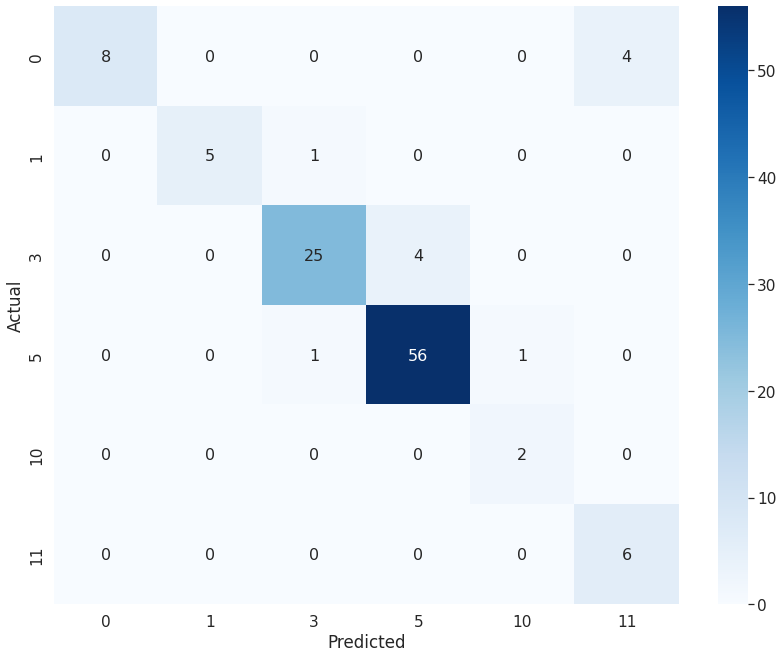

In [19]:
def draw_confusion_matrix():
  target_names = ['0', '1', '3', '5', '10', '11']

  preds, confusion_matrix_data =  predict_test_dataset()
  # preds, confusion_matrix_data =  predict_validate_dataset()
  df_cm = pd.DataFrame(confusion_matrix_data, columns=target_names, index = target_names)
  df_cm.index.name = 'Actual'
  df_cm.columns.name = 'Predicted'
  plt.figure(figsize = (14,11))
  sn.set(font_scale=1.4)#for label size
  sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
draw_confusion_matrix()